<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/4_2_DataProjection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 4.2 Data Projection — Chicago Crime 2017 (Figures 47–52) ===
# Notebook generates Figures 47–52 and exports a transformed CSV for modeling.

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Project paths (keep consistent with your project)
FIG_DIR = "/content/drive/MyDrive/Infosys 722/figs"
TAB_DIR = "/content/drive/MyDrive/Infosys 722/tables"
RAW_CSV = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

print("FIG_DIR:", FIG_DIR)
print("TAB_DIR:", TAB_DIR)


Mounted at /content/drive
FIG_DIR: /content/drive/MyDrive/Infosys 722/figs
TAB_DIR: /content/drive/MyDrive/Infosys 722/tables


In [2]:
# Robust loader for features_district_month.csv (handles file or Spark folder)
features_path = os.path.join(TAB_DIR, "features_district_month.csv")

if os.path.isdir(features_path):
    parts = sorted(glob.glob(os.path.join(features_path, "part-*.csv")))
    if not parts:
        raise FileNotFoundError(f"No part-*.csv found under: {features_path}")
    df = pd.read_csv(parts[0])
else:
    df = pd.read_csv(features_path)

print("Loaded features:", df.shape)
print("Columns:", list(df.columns))

# Helper to pick the first available column among candidates and convert to numeric
def pick_numeric(df_, *names):
    for n in names:
        if n in df_.columns:
            return pd.to_numeric(df_[n], errors="coerce")
    return None

# Build a clean working table (unique District-Month)
base_keys = [c for c in ["District", "Month", "Total"] if c in df.columns]
df_plot = df[base_keys].drop_duplicates() if base_keys else df.copy()

# Ratios (canonical names)
df_plot["District_Month_ArrestRate"]   = pick_numeric(df, "District_Month_ArrestRate", "ArrestRate")
df_plot["District_Month_DomesticRate"] = pick_numeric(df, "District_Month_DomesticRate", "DomesticRate")
df_plot["NightShare_DistMonth"]        = pick_numeric(df, "NightShare_DistMonth", "NightShare")
df_plot["OutdoorShare_DistMonth"]      = pick_numeric(df, "OutdoorShare_DistMonth")

# Counts (canonical names)
df_plot["Roll3Mean_DistMonth"] = pick_numeric(df, "Roll3Mean_DistMonth", "Roll3_Total_imp", "Roll3_Total")

# y_count_next: use existing if present; else compute next month's Total per District
if "y_count_next" in df.columns:
    df_plot["y_count_next"] = pd.to_numeric(df["y_count_next"], errors="coerce")
elif set(["District", "Month", "Total"]).issubset(df_plot.columns):
    ordered = df_plot.sort_values(["District", "Month"]).copy()
    df_plot["y_count_next"] = ordered.groupby("District")["Total"].shift(-1)
else:
    df_plot["y_count_next"] = np.nan

print("Prepared df_plot:", df_plot.shape)
display(df_plot.head())


Loaded features: (267, 15)
Columns: ['District', 'Month', 'Total', 'Arrests', 'Domestics', 'NightCnt', 'ArrestRate', 'DomesticRate', 'NightShare', 'Lag1_Total', 'Lag3_Total', 'Roll3_Total', 'Lag1_Total_imp', 'Lag3_Total_imp', 'Roll3_Total_imp']
Prepared df_plot: (267, 9)


,District,Month,Total,District_Month_ArrestRate,District_Month_DomesticRate,NightShare_DistMonth,OutdoorShare_DistMonth,Roll3Mean_DistMonth,y_count_next
0,NaN,12,1,0.000000,0.000000,0.000000,None,1.000000,NaN
1,1.0,1,1071,0.181139,0.047619,0.090570,None,1071.000000,1018.0
2,1.0,2,1018,0.191552,0.040275,0.079568,None,1044.500000,1186.0
3,1.0,3,1186,0.170320,0.044688,0.087690,None,1091.666667,1201.0
4,1.0,4,1201,0.181515,0.038301,0.093256,None,1135.000000,1252.0


In [3]:
# If OutdoorShare_DistMonth is missing or entirely NaN, compute from RAW_CSV
need_outdoor = ("OutdoorShare_DistMonth" not in df_plot.columns) or df_plot["OutdoorShare_DistMonth"].isna().all()

if need_outdoor:
    try:
        raw = pd.read_csv(RAW_CSV, parse_dates=["Date"], low_memory=False)

        # Year filter for 2017
        if "Year" in raw.columns:
            raw = raw[raw["Year"] == 2017].copy()
        else:
            raw = raw[raw["Date"].dt.year == 2017].copy()

        # Month
        if "Month" not in raw.columns:
            raw["Month"] = raw["Date"].dt.month

        # District numeric
        if "District" in raw.columns:
            raw["District"] = pd.to_numeric(raw["District"], errors="coerce")
        else:
            raise ValueError("Column 'District' not found in raw CSV.")

        # Find location description column
        loc_col = None
        for cand in ["Location Description", "Location_Description", "Location_Desc", "Location"]:
            if cand in raw.columns:
                loc_col = cand
                break
        if loc_col is None:
            raise ValueError("Location description column not found in raw CSV.")

        raw[loc_col] = raw[loc_col].fillna("").astype(str).str.upper().str.strip()

        # Outdoor categories (can be extended if needed)
        outdoor_set = {
            "STREET","SIDEWALK","ALLEY","PARK","PARK PROPERTY",
            "PARKING LOT/GARAGE(NON.RESID.)","HIGHWAY/EXPRESSWAY","DRIVEWAY",
            "SIDE OF ROAD","VACANT LOT/LAND","YARD","BEACH","BRIDGE",
            "FOREST PRESERVE","RIVER","BOAT/WATERCRAFT","LAKEFRONT/WATERFRONT",
            "SIDEWALK/STREET","BIKE PATH","PLAYLOT","SPORTS ARENA/STADIUM"
        }
        raw["is_outdoor"] = raw[loc_col].isin(outdoor_set)

        grp = (raw.groupby(["District", "Month"])["is_outdoor"]
                 .agg(["sum", "count"]).reset_index())
        grp["OutdoorShare_DistMonth"] = grp["sum"] / grp["count"]

        df_plot = df_plot.merge(
            grp[["District", "Month", "OutdoorShare_DistMonth"]],
            on=["District", "Month"], how="left", suffixes=("", "_fromraw")
        )

        if "OutdoorShare_DistMonth_fromraw" in df_plot.columns:
            df_plot["OutdoorShare_DistMonth"] = df_plot["OutdoorShare_DistMonth"].fillna(
                df_plot["OutdoorShare_DistMonth_fromraw"]
            )
            df_plot.drop(columns=["OutdoorShare_DistMonth_fromraw"], inplace=True)

        print("OutdoorShare_DistMonth computed from raw and merged.")
    except Exception as e:
        print("Warning: could not compute OutdoorShare_DistMonth from raw CSV:", e)

print("OutdoorShare non-null:",
      df_plot["OutdoorShare_DistMonth"].notna().sum() if "OutdoorShare_DistMonth" in df_plot.columns else 0)


/tmp/ipython-input-1264157203.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw = pd.read_csv(RAW_CSV, parse_dates=["Date"], low_memory=False)


OutdoorShare_DistMonth computed from raw and merged.
OutdoorShare non-null: 266


/tmp/ipython-input-1264157203.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot["OutdoorShare_DistMonth"] = df_plot["OutdoorShare_DistMonth"].fillna(


In [4]:
# Helper to put figure caption at bottom center
def fig_caption(fig, label, idx=None):
    cap = f"Hist_{label.replace(' ', '_')}"
    if idx is not None:
        cap = f"Figure {idx}: {cap}"
    plt.figtext(0.5, -0.06, cap, ha="center", fontsize=12, style="italic")
    fig.suptitle("")  # ensure no top suptitle

# Ratio — before/after with logit transform
def plot_hist_pair_ratio(series, label, filename, idx=None, bins=30, eps=1e-6):
    s0 = pd.to_numeric(series, errors="coerce").dropna().clip(eps, 1 - eps)
    if s0.empty:
        print(f"Skip {label}: no data")
        return
    s1 = np.log(s0 / (1 - s0))  # logit

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    axes[0].hist(s0, bins=bins)
    axes[0].set_title(f"{label} — Before")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(s1, bins=bins)
    axes[1].set_title(f"{label} — After")
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Frequency")

    fig_caption(fig, label, idx)
    fig.tight_layout()
    out_path = os.path.join(FIG_DIR, filename)
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    display(fig)
    plt.close(fig)

# Count — before/after with log1p transform
def plot_hist_pair_count(series, label, filename, idx=None, bins=30):
    s0 = pd.to_numeric(series, errors="coerce").dropna()
    s0 = s0[s0 >= 0]  # counts must be non-negative
    if s0.empty:
        print(f"Skip {label}: no non-negative data")
        return
    s1 = np.log1p(s0)  # log(1+x)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    axes[0].hist(s0, bins=bins)
    axes[0].set_title(f"{label} — Before")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(s1, bins=bins)
    axes[1].set_title(f"{label} — After")
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Frequency")

    fig_caption(fig, label, idx)
    fig.tight_layout()
    out_path = os.path.join(FIG_DIR, filename)
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    display(fig)
    plt.close(fig)


In [5]:
# If Roll3Mean_DistMonth is missing, compute a 3-month rolling mean per District
if "Roll3Mean_DistMonth" not in df_plot.columns and {"District", "Month", "Total"}.issubset(df_plot.columns):
    ordered = df_plot.sort_values(["District", "Month"]).copy()
    roll = ordered.groupby("District")["Total"].apply(lambda s: s.rolling(window=3, min_periods=1).mean())
    df_plot["Roll3Mean_DistMonth"] = roll.reset_index(level=0, drop=True)

# If y_count_next is missing, compute next month's Total per District
if "y_count_next" not in df_plot.columns and {"District", "Month", "Total"}.issubset(df_plot.columns):
    ordered = df_plot.sort_values(["District", "Month"]).copy()
    df_plot["y_count_next"] = ordered.groupby("District")["Total"].shift(-1)

print("Ready for plotting. Columns present?")
for c in ["District_Month_ArrestRate","District_Month_DomesticRate",
          "NightShare_DistMonth","OutdoorShare_DistMonth",
          "Roll3Mean_DistMonth","y_count_next"]:
    print(f"  - {c}: {'yes' if c in df_plot.columns else 'no'}")


Ready for plotting. Columns present?
  - District_Month_ArrestRate: yes
  - District_Month_DomesticRate: yes
  - NightShare_DistMonth: yes
  - OutdoorShare_DistMonth: yes
  - Roll3Mean_DistMonth: yes
  - y_count_next: yes


Saved: /content/drive/MyDrive/Infosys 722/figs/fig47_arrestrate_logit.png


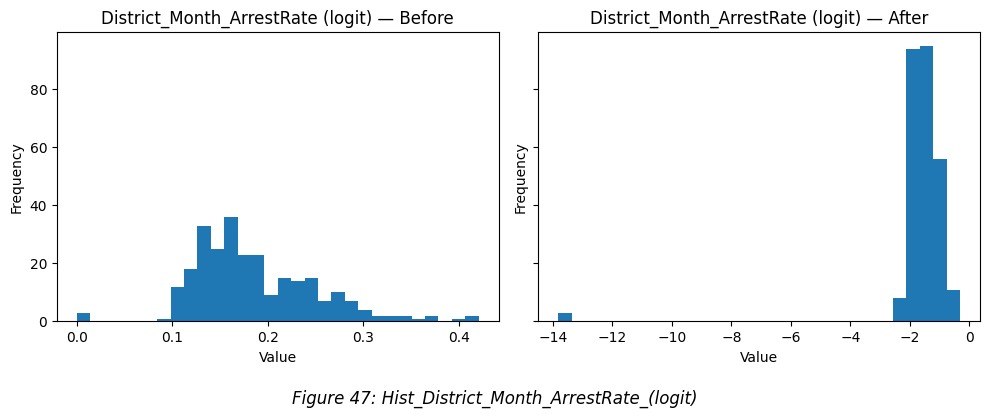

Saved: /content/drive/MyDrive/Infosys 722/figs/fig48_domesticrate_logit.png


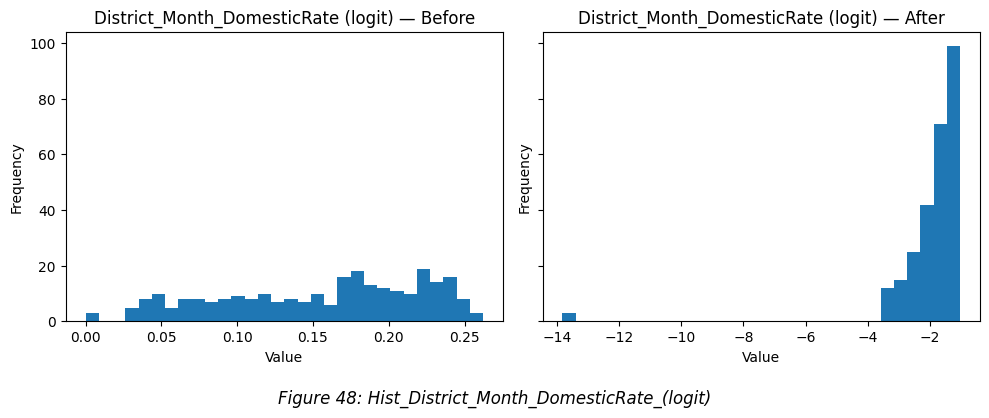

Saved: /content/drive/MyDrive/Infosys 722/figs/fig49_nightshare_logit.png


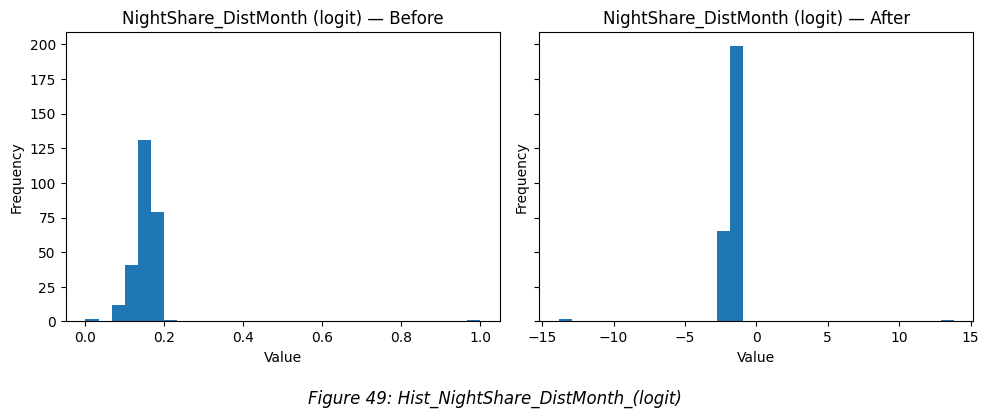

Saved: /content/drive/MyDrive/Infosys 722/figs/fig50_outdoorshare_logit.png


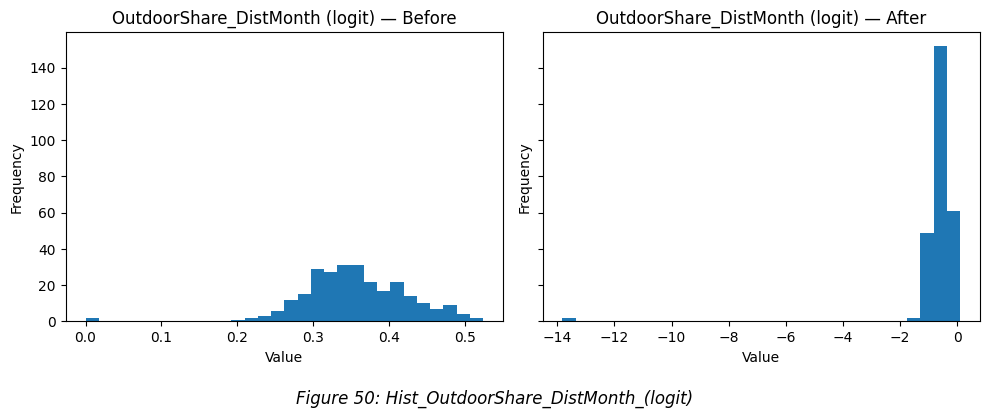

Saved: /content/drive/MyDrive/Infosys 722/figs/fig51_roll3mean_log1p.png


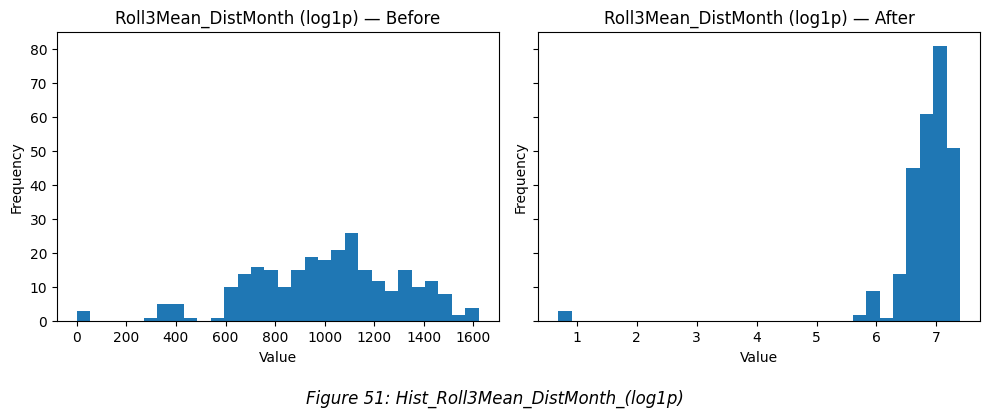

Saved: /content/drive/MyDrive/Infosys 722/figs/fig52_y_count_next_log1p.png


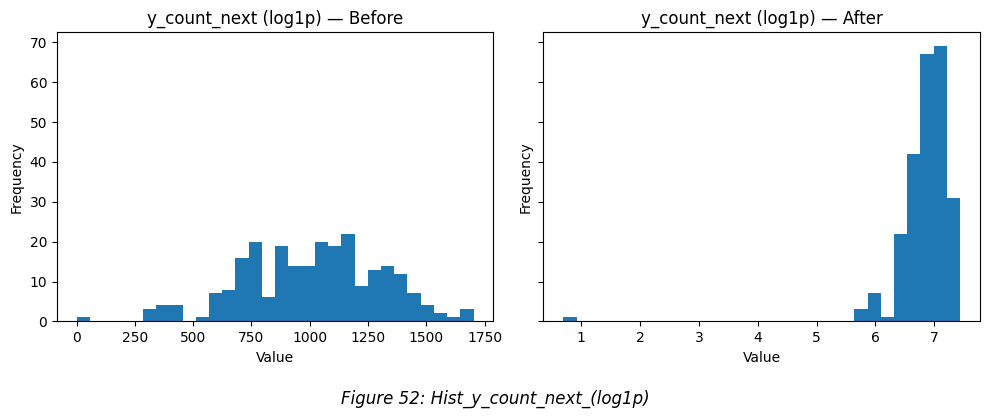

In [6]:
# Figures 47–50: ratios (logit)
if "District_Month_ArrestRate" in df_plot.columns:
    plot_hist_pair_ratio(df_plot["District_Month_ArrestRate"],
                         "District_Month_ArrestRate (logit)",
                         "fig47_arrestrate_logit.png", idx=47)

if "District_Month_DomesticRate" in df_plot.columns:
    plot_hist_pair_ratio(df_plot["District_Month_DomesticRate"],
                         "District_Month_DomesticRate (logit)",
                         "fig48_domesticrate_logit.png", idx=48)

if "NightShare_DistMonth" in df_plot.columns:
    plot_hist_pair_ratio(df_plot["NightShare_DistMonth"],
                         "NightShare_DistMonth (logit)",
                         "fig49_nightshare_logit.png", idx=49)

if "OutdoorShare_DistMonth" in df_plot.columns:
    plot_hist_pair_ratio(df_plot["OutdoorShare_DistMonth"],
                         "OutdoorShare_DistMonth (logit)",
                         "fig50_outdoorshare_logit.png", idx=50)

# Figure 51: counts (log1p)
if "Roll3Mean_DistMonth" in df_plot.columns:
    plot_hist_pair_count(df_plot["Roll3Mean_DistMonth"],
                         "Roll3Mean_DistMonth (log1p)",
                         "fig51_roll3mean_log1p.png", idx=51)

# Figure 52: target-like counts (log1p)
if "y_count_next" in df_plot.columns:
    plot_hist_pair_count(df_plot["y_count_next"],
                         "y_count_next (log1p)",
                         "fig52_y_count_next_log1p.png", idx=52)


In [7]:
# Build the transformed dataset for modeling (Data Reduction + Projection outputs)

df_transformed = df_plot.copy()

# Logit transforms for ratio variables (add as new columns)
def logit_safe(p_series, eps=1e-6):
    p = p_series.clip(eps, 1 - eps)
    return np.log(p / (1 - p))

if "District_Month_ArrestRate" in df_plot.columns:
    df_transformed["District_Month_ArrestRate_logit"] = logit_safe(df_plot["District_Month_ArrestRate"])

if "District_Month_DomesticRate" in df_plot.columns:
    df_transformed["District_Month_DomesticRate_logit"] = logit_safe(df_plot["District_Month_DomesticRate"])

if "NightShare_DistMonth" in df_plot.columns:
    df_transformed["NightShare_DistMonth_logit"] = logit_safe(df_plot["NightShare_DistMonth"])

if "OutdoorShare_DistMonth" in df_plot.columns:
    df_transformed["OutdoorShare_DistMonth_logit"] = logit_safe(df_plot["OutdoorShare_DistMonth"])

# log1p transforms for count variables (add as new columns)
if "Roll3Mean_DistMonth" in df_plot.columns:
    df_transformed["Roll3Mean_DistMonth_log1p"] = np.log1p(df_plot["Roll3Mean_DistMonth"])

if "y_count_next" in df_plot.columns:
    df_transformed["y_count_next_log1p"] = np.log1p(df_plot["y_count_next"])

# Export CSV for downstream modeling
out_csv = os.path.join(TAB_DIR, "CrimeData2017_reduced_projected.csv")
df_transformed.to_csv(out_csv, index=False)
print("Saved transformed dataset:", out_csv)
display(df_transformed.head())


Saved transformed dataset: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv


,District,Month,Total,District_Month_ArrestRate,District_Month_DomesticRate,NightShare_DistMonth,OutdoorShare_DistMonth,Roll3Mean_DistMonth,y_count_next,District_Month_ArrestRate_logit,District_Month_DomesticRate_logit,NightShare_DistMonth_logit,OutdoorShare_DistMonth_logit,Roll3Mean_DistMonth_log1p,y_count_next_log1p
0,NaN,12,1,0.000000,0.000000,0.000000,NaN,1.000000,NaN,-13.815510,-13.815510,-13.815510,NaN,0.693147,NaN
1,1.0,1,1071,0.181139,0.047619,0.090570,0.195145,1071.000000,1018.0,-1.508649,-2.995732,-2.306700,-1.416921,6.977281,6.926577
2,1.0,2,1018,0.191552,0.040275,0.079568,0.221022,1044.500000,1186.0,-1.439957,-3.170915,-2.448234,-1.259723,6.952251,7.079184
3,1.0,3,1186,0.170320,0.044688,0.087690,0.212479,1091.666667,1201.0,-1.583358,-3.062332,-2.342176,-1.310047,6.996376,7.091742
4,1.0,4,1201,0.181515,0.038301,0.093256,0.241465,1135.000000,1252.0,-1.506114,-3.223214,-2.274516,-1.144662,7.035269,7.133296
